In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "vanLoggerenberg_HMBS_ubiquitous"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [3]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [4]:
scoreset

,accession,hgvs_nt,hgvs_splice,hgvs_pro,score,sd,df,se,author_transcript,synonymous,nonsense
0,urn:mavedb:00000108-a-1#1,NaN,NaN,p.Val94Tyr,0.078732,0.240569,2,0.170108,NM_000190.4,False,False
1,urn:mavedb:00000108-a-1#2,NaN,NaN,p.Val94Trp,-0.641036,0.184045,2,0.130139,NM_000190.4,False,False
2,urn:mavedb:00000108-a-1#3,NaN,NaN,p.Val94Thr,0.456650,0.345503,4,0.172751,NM_000190.4,False,False
3,urn:mavedb:00000108-a-1#4,NaN,NaN,p.Val94Ter,0.548358,0.207878,2,0.146992,NM_000190.4,False,True
4,urn:mavedb:00000108-a-1#5,NaN,NaN,p.Val94Ser,-0.193890,0.461795,6,0.188527,NM_000190.4,False,False
...,...,...,...,...,...,...,...,...,...,...,...
6039,urn:mavedb:00000108-a-1#6040,NaN,NaN,p.Ala112Cys,1.102460,0.129974,2,0.091905,NM_000190.4,False,False
6040,urn:mavedb:00000108-a-1#6041,NaN,NaN,p.Ala112Asp,-0.035792,0.390035,4,0.195018,NM_000190.4,False,False
6041,urn:mavedb:00000108-a-1#6042,NaN,NaN,p.Ala112Asn,-0.631452,0.714959,2,0.505553,NM_000190.4,False,False
6042,urn:mavedb:00000108-a-1#6043,NaN,NaN,p.Ala112Arg,-0.533869,0.488109,4,0.244055,NM_000190.4,False,False


In [5]:
if "author_transcript" not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [6]:
AUTHOR_TRANSCRIPT

'NM_000190'

# Add ClinVar annotations

In [7]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

  0%|          | 0/311 [00:00<?, ?it/s]

100%|██████████| 311/311 [00:00<00:00, 1986.80it/s]


In [8]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

# Add gnomAD annotations

In [9]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [10]:
Ensembl_transcript_stable_ids

array(['ENST00000652429'], dtype=object)

In [11]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [12]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [13]:
scoreset_processed

,hgvs_pro,accession,hgvs_nt,hgvs_splice,score,sd,df,se,author_transcript,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Val94Tyr,urn:mavedb:00000108-a-1#1,NaN,NaN,0.078732,0.240569,2,0.170108,NM_000190.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Val94Trp,urn:mavedb:00000108-a-1#2,NaN,NaN,-0.641036,0.184045,2,0.130139,NM_000190.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p.Val94Thr,urn:mavedb:00000108-a-1#3,NaN,NaN,0.456650,0.345503,4,0.172751,NM_000190.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p.Val94Ter,urn:mavedb:00000108-a-1#4,NaN,NaN,0.548358,0.207878,2,0.146992,NM_000190.4,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p.Val94Ser,urn:mavedb:00000108-a-1#5,NaN,NaN,-0.193890,0.461795,6,0.188527,NM_000190.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,p.Ala112Cys,urn:mavedb:00000108-a-1#6040,NaN,NaN,1.102460,0.129974,2,0.091905,NM_000190.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6040,p.Ala112Asp,urn:mavedb:00000108-a-1#6041,NaN,NaN,-0.035792,0.390035,4,0.195018,NM_000190.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.849860e-07,0.03,11:119089751:C:A|11:119089751:C:A
6041,p.Ala112Asn,urn:mavedb:00000108-a-1#6042,NaN,NaN,-0.631452,0.714959,2,0.505553,NM_000190.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6042,p.Ala112Arg,urn:mavedb:00000108-a-1#6043,NaN,NaN,-0.533869,0.488109,4,0.244055,NM_000190.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [8]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [15]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [16]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

INVERT_SCORES = False
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)

In [17]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 31
B/LB: 59
gnomAD: 336
synonymous: 63


(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object))

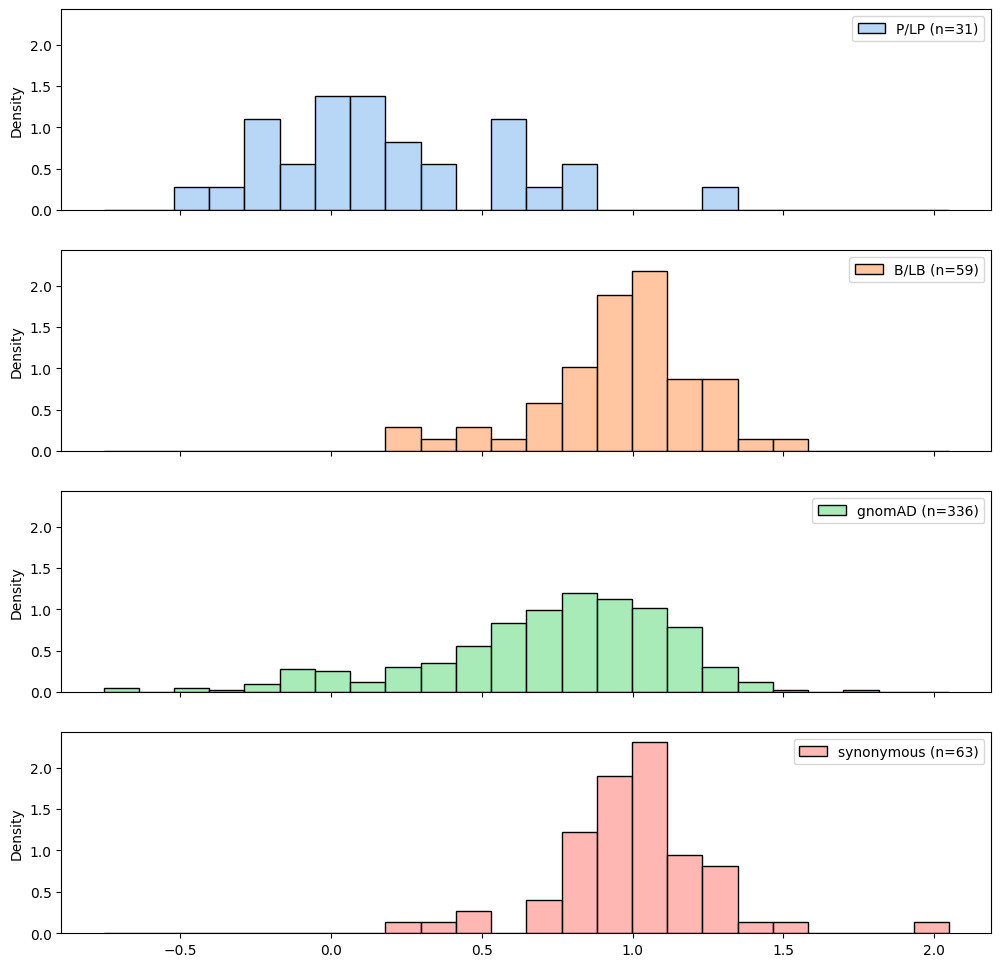

In [18]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [19]:
if 'synonymous' in sample_data:
    pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                                *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                                *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                                *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)
else:
    pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)

In [20]:
old = joblib.load(dataset_path / "hgvs_pro.pkl")

In [21]:
clinvar_hgvs_pro_summaries[clinvar_hgvs_pro_summaries.index.isin(set(old['p_lp'].values) - set(sample_data['P/LP'].hgvs_pro.values))]

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
p.Arg167Gln,1,0,0,0,NM_000190.4(HMBS):c.500G>A (p.Arg167Gln),1,0.80
p.Gln204His,1,0,0,0,NM_000190.4(HMBS):c.612G>T (p.Gln204His),1,0.96
p.Gly236Ser,1,0,0,0,NM_000190.4(HMBS):c.706G>A (p.Gly236Ser),1,0.68


In [22]:
clinvar_hgvs_pro_summaries[clinvar_hgvs_pro_summaries.index.isin(set(old['b_lb'].values) - set(sample_data['B/LB'].hgvs_pro.values))]

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
p.Pro241=,0,1,1,0,NM_000190.4(HMBS):c.723C>T (p.Pro241=)|NM_0001...,2,0.05
p.Val90=,0,1,0,0,NM_000190.4(HMBS):c.270G>A (p.Val90=),1,0.71
